/home/aayush/Desktop/intern/quanturf/pypi_quanturf_pkg/venv/lib/python3.11/site-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


Fama French Factor Model - Large Cap Portfolio:
                            OLS Regression Results                            
Dep. Variable:      Large Cap Returns   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     11.53
Date:                Mon, 22 May 2023   Prob (F-statistic):           1.50e-07
Time:                        15:26:17   Log-Likelihood:                 6385.5
No. Observations:               20137   AIC:                        -1.276e+04
Df Residuals:                   20133   BIC:                        -1.273e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

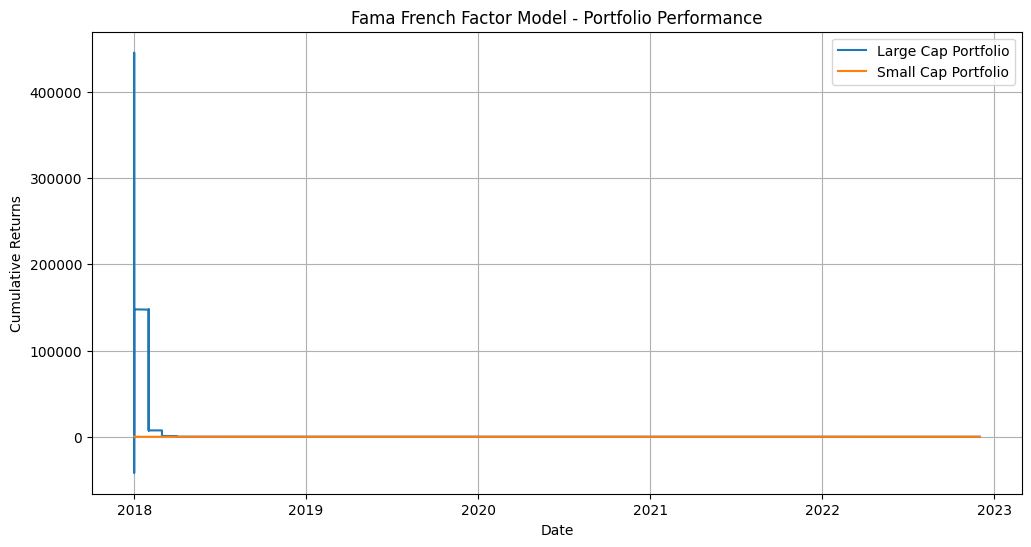



Large Cap Portfolio:
Total Return: -100.00%
Profit: $-100000.02


Small Cap Portfolio:
Total Return: -100.00%
Profit: $-100000.02


In [5]:
# Fama French Factor Model Trading Strategy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import statsmodels.api as sm
import alpaca_trade_api as tradeapi
import os
from dotenv import load_dotenv

load_dotenv()

# Set up Alpaca API
API_KEY=os.getenv('API_KEY')
SECRET_KEY=os.getenv('SECRET_KEY')
BASE_URL = 'https://paper-api.alpaca.markets'

# Set the Alpaca API endpoint and authentication
api = tradeapi.REST(API_KEY, SECRET_KEY, base_url=BASE_URL, api_version='v2')

# Define the start and end dates for the data
start_date = '2018-01-01'
end_date = '2022-12-31'
INTERVAL='1D'

# Define the stock tickers for the large-cap and small-cap portfolios
large_cap_tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG']
small_cap_tickers = ['AXP', 'CAT', 'DIS', 'IBM']

# Fetch stock price data from Alpaca
large_cap_data = api.get_bars(large_cap_tickers, timeframe=INTERVAL, start=start_date, end=end_date).df
small_cap_data = api.get_bars(small_cap_tickers, timeframe=INTERVAL, start=start_date, end=end_date).df

# Calculate the daily returns for the large-cap and small-cap portfolios
large_cap_returns = large_cap_data['close'].pct_change().dropna()
small_cap_returns = small_cap_data['close'].pct_change().dropna()

# Fetch Fama French factor data using Pandas DataReader
ff_factors = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start=start_date, end=end_date)[0]

# Merge the Fama French factor data with the stock returns
returns = pd.merge(large_cap_returns, small_cap_returns, how='inner', left_index=True, right_index=True)
returns.columns = ['Large Cap Returns', 'Small Cap Returns']
returns.index = returns.index.to_period('M')
ff_factors.index = ff_factors.index
# returns.index = returns.index.to_period('M')
ff_data = pd.merge(returns, ff_factors, how='inner', left_index=True, right_index=True)

# Define the independent variables (market risk, size risk, value risk)
X = ff_data[['Mkt-RF', 'SMB', 'HML']]
X = sm.add_constant(X)  # Add a constant term for the intercept

# Define the dependent variables (stock returns)
y_large = ff_data['Large Cap Returns']
y_small = ff_data['Small Cap Returns']

# Fit the Fama French factor model to the large-cap and small-cap portfolios
model_large = sm.OLS(y_large, X)
result_large = model_large.fit()

model_small = sm.OLS(y_small, X)
result_small = model_small.fit()

# Print the Fama French factor model results for the large-cap portfolio
print("Fama French Factor Model - Large Cap Portfolio:")
print(result_large.summary())
print("\n")

# Print the Fama French factor model results for the small-cap portfolio
print("Fama French Factor Model - Small Cap Portfolio:")
print(result_small.summary())
print("\n")

# Calculate the predicted returns based on the Fama French factor model
ff_data['Large Cap Predicted Returns'] = result_large.predict(X)
ff_data['Small Cap Predicted Returns'] = result_small.predict(X)

# Define the trading strategy based on value and size
ff_data['Large Cap Signal'] = np.where(
    (ff_data['Large Cap Returns'] > ff_data['Large Cap Predicted Returns']) &
    (ff_data['HML'] < 0),
    -1,
    np.where(
        (ff_data['Large Cap Returns'] < ff_data['Large Cap Predicted Returns']) &
        (ff_data['HML'] > 0),
        1,
        0
    )
)

ff_data['Small Cap Signal'] = np.where(
    (ff_data['Small Cap Returns'] > ff_data['Small Cap Predicted Returns']) &
    (ff_data['HML'] < 0),
    -1,
    np.where(
        (ff_data['Small Cap Returns'] < ff_data['Small Cap Predicted Returns']) &
        (ff_data['HML'] > 0),
        1,
        0
    )
)

# Calculate the portfolio returns
ff_data['Large Cap Portfolio Returns'] = ff_data['Large Cap Signal'] * ff_data['Large Cap Returns']
ff_data['Small Cap Portfolio Returns'] = ff_data['Small Cap Signal'] * ff_data['Small Cap Returns']

# Calculate the cumulative returns of the portfolios
ff_data['Large Cap Cumulative Returns'] = (1 + ff_data['Large Cap Portfolio Returns']).cumprod()
ff_data['Small Cap Cumulative Returns'] = (1 + ff_data['Small Cap Portfolio Returns']).cumprod()

ff_data.index = ff_data.index.to_timestamp()

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(ff_data.index, ff_data['Large Cap Cumulative Returns'], label='Large Cap Portfolio')
plt.plot(ff_data.index, ff_data['Small Cap Cumulative Returns'], label='Small Cap Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Fama French Factor Model - Portfolio Performance')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the total return and profit of the portfolios
large_cap_total_return = ff_data['Large Cap Cumulative Returns'][-1] - 1
small_cap_total_return = ff_data['Small Cap Cumulative Returns'][-1] - 1

large_cap_profit = large_cap_total_return * float(api.get_account().equity)
small_cap_profit = small_cap_total_return * float(api.get_account().equity)

# Print the total return and profit of the portfolios
print("\n")
print("Large Cap Portfolio:")
print("Total Return: {:.2%}".format(large_cap_total_return))
print("Profit: ${:.2f}".format(large_cap_profit))
print("\n")

print("Small Cap Portfolio:")
print("Total Return: {:.2%}".format(small_cap_total_return))
print("Profit: ${:.2f}".format(small_cap_profit))